In [2]:
import pystan
import bebi103
import numpy as np
import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()
import matplotlib.pyplot as plt
import scipy.io
import trackball_suite
import time

%matplotlib notebook

Loading BokehJS ...

## Define the dynamic logistic regression model

In [3]:
behavior_inference_model_code = """
data {
  int N;
  int y[N];
  vector[N] g1;
  vector[N] g2;
  vector[N] g3;
  vector[N] g4;
}


parameters {
  vector[N] n1;
  vector[N] n2;
  vector[N] n3;
  vector[N] n4;
}


transformed parameters {
  vector[N] evidence;
  vector<lower=0.0, upper=1>[N] prob;
  
  vector[N] w1;
  vector[N] w2;
  vector[N] w3;
  vector[N] w4;
  
  w1[1] = n1[1];
  w2[1] = n2[1];
  w3[1] = n3[1];
  w4[1] = n4[1];
  
  for (i in 2:N) {
    w1[i] = w1[i-1] + n1[i];
    w2[i] = w2[i-1] + n2[i];
    w3[i] = w3[i-1] + n3[i];
    w4[i] = w4[i-1] + n4[i];
  }
  
  evidence = g1 .* w1 + g2 .* w2 + g3 .* w3 + g4 .* w4;
  prob = 1.0 ./ (1.0 + exp(-evidence));
  
  // Constrain prob to be not too high and not too low
  prob = prob * 0.998 + 0.001;
}

model {
  // Priors
  print(1, target())
  n1[1] ~ normal(0, 16);
  n2[1] ~ normal(0, 16);
  n3[1] ~ normal(0, 16);
  n4[1] ~ normal(0, 16);

  for (i in 2:N) {
    n1[i] ~ normal(0, 1.0/32);
    n2[i] ~ normal(0, 1.0/64);
    n3[i] ~ normal(0, 1.0/128);
    n4[i] ~ normal(0, 1.0/64);
  }
  print(1, prob);
  print(2, target());
  // Likelihood
  y ~ bernoulli(prob);
}
"""

beh_inf = pystan.StanModel(model_code=behavior_inference_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ffad84a133b9e4453a7606fe3de5ee7a NOW.


## Generate fake data to test the inference

In [4]:
# Fake data for simple inference
#np.random.seed(12334)
N = 500
sigma1 = 1 / 32
sigma2 = 1 / 64
sigma3 = 1 / 128
sigma4 = 1 / 64
sigmaG = 1

n1 = np.random.normal(0, sigma1, size=N)
n2 = np.random.normal(0, sigma2, size=N)
n3 = np.random.normal(0, sigma3, size=N)
n4 = np.random.normal(0, sigma4, size=N)

w1 = np.cumsum(n1) + np.random.normal(0, 1)
w2 = np.cumsum(n2) + np.random.normal(0, 1)
w3 = np.cumsum(n3) + np.random.normal(0, 1)
w4 = np.cumsum(n4) + np.random.normal(0, 1)

g1 = np.random.normal(0, sigmaG, size=N)
g2 = np.random.normal(0, sigmaG, size=N)
g3 = np.random.normal(0, sigmaG, size=N)
g4 = np.random.normal(0, sigmaG, size=N)

evidence = g1 * w1 + g2 * w2 + g3 * w3 + g4 * w4;
prob = 1.0/(1.0 + np.exp(-evidence))
prob = prob * 0.998 + 0.001
samples = np.random.rand(len(prob))
yvals = (samples < prob).astype('int')

<IPython.core.display.Javascript object>


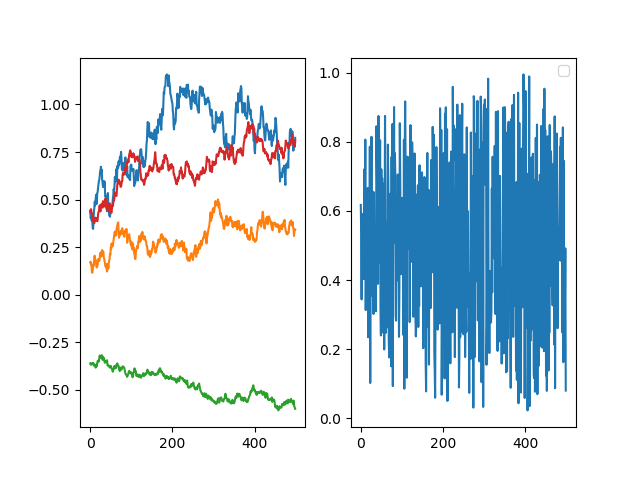

In [5]:
plt.figure()
plt.subplot(121)
plt.plot(w1, label='w1')
plt.plot(w2, label='w2')
plt.plot(w3, label='w3')
plt.plot(w4, label='w4')
plt.subplot(122)
plt.plot(prob)
plt.legend()

## Perform the sampling from the posterior

In [13]:
data_inf = dict(N=N,
               y=yvals.astype('int'),
               g1=g1,
               g2=g2, g3=g3, g4=g4)

init_prob = [dict(prob=np.ones(N) * 0.1)] * 4
samples_beh_inf = beh_inf.sampling(data=data_inf, warmup=1000, iter=1500, control={'max_treedepth':18}, init=init_prob)

<IPython.core.display.Javascript object>


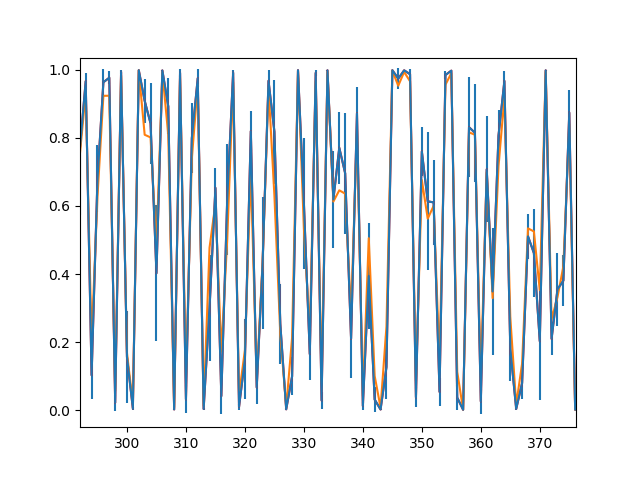

In [23]:
# Get samples of w1 and plot
n1samp = samples_beh_inf['prob']
means = np.mean(n1samp, axis=0)
std = np.std(n1samp, axis=0)
plt.figure(5)

plt.errorbar(np.arange(N), means, 1.96 * std)
plt.plot(means, 'r')
plt.plot(prob)

## Diagnostics

In [15]:
bebi103.stan.check_all_diagnostics(samples_beh_inf)

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 2000 (0.0%) iterations ended with a divergence.
0 of 2000 (0.0%) iterations saturated the maximum tree depth of 18.
E-BFMI indicated no pathological behavior.


0

In [66]:
transformation = lambda x: (x - np.mean(x)) / np.std(x)

bokeh.io.show(bebi103.viz.parcoord_plot(samples_beh_inf, 
                                        transformation=transformation, 
                                        pars=['w1[1]', 'w2[1]', 'w3[1]', 'w4[1]', 'prob[1]'],
                                       divergence_alpha=0.1, 
                                        divergence_line_width=0.5))

In [16]:
bokeh.io.show(bebi103.viz.trace_plot(samples_beh_inf, 
                                     pars=['w1[1]', 'w2[1]', 'w3[1]', 'w4[1]', 'prob[1]'], 
                                     inc_warmup=True))

In [68]:
bokeh.io.show(bebi103.viz.corner(samples_beh_inf, 
                                 pars=['w1[1]', 'w2[1]', 'w3[1]', 'w4[1]', 'prob[1]'],
                                 labels=['w1[1]', 'w2[1]', 'w3[1]', 'w4[1]', 'prob[1]']))

## Apply the model to behavioral data

In [9]:
# Load the data
folder = 'C:\\Users\\Sur lab\\Dropbox (MIT)\\trackball-behavior\\Data\\C13\\laser_analys_FebMar2019_left\\'
filename = '20190220_trackball_0013.mat'
data = scipy.io.loadmat(folder + filename)
group = trackball_suite.SessionGroup(folder)

session = trackball_suite.Session(sourcefile)

stim = session.get_stim() - 1
choice = session.get_choice() - 1
choice[choice == 4] = 0
opp_contrast =session.get_opp_contrast()
laser = session.get_laser() - 1


In [10]:
group.sessions

In [7]:
# Fake data for behavioral inference
np.random.seed(12334)
N = len(stim) - 1
sigma1 = 1 / 32
sigma2 = 1 / 64
sigma3 = 1 / 128
sigma4 = 1 / 64
sigmaG = 1

n1 = np.random.normal(0, sigma1, size=N)
n2 = np.random.normal(0, sigma2, size=N)
n3 = np.random.normal(0, sigma3, size=N)
n4 = np.random.normal(0, sigma4, size=N)

w1 = np.cumsum(n1) + np.random.normal(0, 0.5)
w2 = np.cumsum(n2) + np.random.normal(0, 0.5)
w3 = np.cumsum(n3) + np.random.normal(0, 0.5)
w4 = np.cumsum(n4) + np.random.normal(0, 0.5)

bias = np.ones(N) # bias
curr_stim = stim[1:] # current L/R stimulus
opp = opp_contrast[1:] # opposite contrast
prev_stim = stim[:-1] # previous stim

g1 = bias
g2 = curr_stim
g3 = opp
g4 = prev_stim

evidence = g1 * w1 + g2 * w2 + g3 * w3 + g4 * w4;
prob = 1.0/(1.0 + np.exp(-evidence))
prob = prob * 0.998 + 0.001
samples = np.random.rand(len(prob))
yvals = (samples < prob).astype('int')

<IPython.core.display.Javascript object>


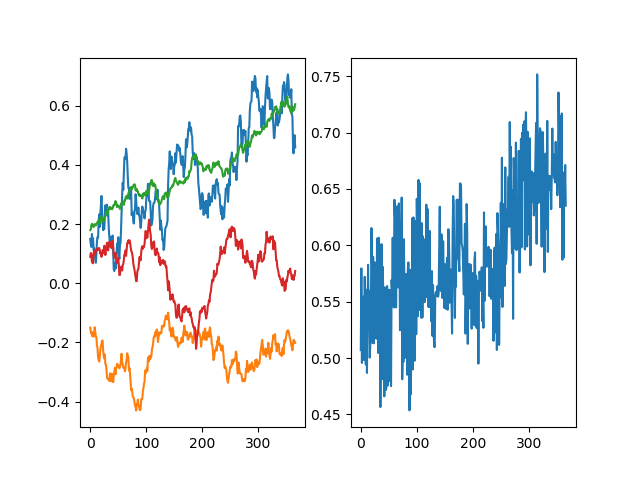

In [8]:
plt.figure()
plt.subplot(121)
plt.plot(w1, label='w1')
plt.plot(w2, label='w2')
plt.plot(w3, label='w3')
plt.plot(w4, label='w4')
plt.subplot(122)
plt.plot(prob)


In [106]:
# Begin to sample

data_inf = dict(N=N,
               y=choice[1:].astype('int'),
               g1=g1[:N],
               g2=g2[:N], g3=g3[:N], g4=g4[:N])

init_prob = [dict(prob=np.ones(N) * 0.1)] * 4
startT = time.time()
samples_beh_inf = beh_inf.sampling(data=data_inf, warmup=100, iter=200, control={'max_treedepth':18}, init=init_prob)
endT = time.time()

In [99]:
def get_mean_std(samples, tag=''):
    plt.figure(3)
    means = np.mean(samples, axis=0)
    std = np.std(samples, axis=0)
    #plt.plot(means)
    #plt.errorbar(np.arange(len(means)), means, 1.96 * std, label=tag)
    
    return means, std

<IPython.core.display.Javascript object>


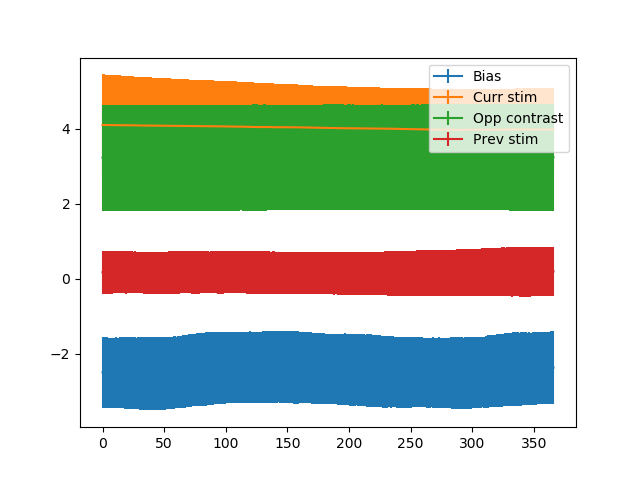

In [113]:
# Get samples of w1 and plot
n1samp = samples_beh_inf['w1']
n2samp = samples_beh_inf['w2']
n3samp = samples_beh_inf['w3']
n4samp = samples_beh_inf['w4']

means1, std1 = get_mean_std(n1samp, tag='w1')
means2, std2 = get_mean_std(n2samp, tag='w2')
means3, std3 = get_mean_std(n3samp, tag='w3')
means4, std4 = get_mean_std(n4samp, tag='w4')
plt.figure(3)
plt.legend()

#plt.figure(5)

#plt.errorbar(np.arange(N), means, 1.96 * std)
#plt.plot(means, 'r')
#plt.plot(w1, 'r')
#plt.plot(w2, 'g')
#plt.plot(w3, 'b')
#plt.plot(w4, 'k')

plt.errorbar(np.arange(N), means1, 1.96 * std1, label='Bias')
plt.errorbar(np.arange(N), means2, 1.96 * std2, label='Curr stim')
plt.errorbar(np.arange(N), means3, 1.96 * std3, label='Opp contrast')
plt.errorbar(np.arange(N), means4, 1.96 * std4, label='Prev stim')
#plt.plot(means1, 'r--', label='Bias')
#plt.plot(means2, 'g--', label='Curr stim')
#plt.plot(means3, 'b--', label='Opp contrast')
#plt.plot(means4, 'k--', label='Prev stim')
plt.legend()